In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils

In [3]:
BETA = 2000

# Load Data

In [4]:
train_data = utils.image_dataset_from_directory(
    "../data/CelebA/img_align_celeba",labels=None,
    color_mode="rgb",
    image_size=(64,64),
    batch_size=128,
    shuffle=True,
    seed=42,
    interpolation="bilinear"
)

Found 202599 files belonging to 1 classes.


In [5]:
def process(imgs):
    imgs = tf.cast(imgs,"float32")/255
    return imgs

In [6]:
train_data = train_data.map(lambda x:process(x))

In [7]:
from tensorflow.keras import models,layers,metrics,losses
import tensorflow.keras.backend as K
from tensorflow.keras.utils import register_keras_serializable

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder

In [9]:
encoder_input = layers.Input(shape=(64,64,3))
x = layers.Conv2D(128,kernel_size=3,strides=2,padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128,kernel_size=3,strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128,kernel_size=3,strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128,kernel_size=3,strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(200, name="z_mean")(x)
z_log_var = layers.Dense(200, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)          0         ['batch_normalization[0]

# Decoder

In [10]:
# Decoder
decoder_input = layers.Input(shape=(200,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    128, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    128, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    128, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    3, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 2048)              411648    
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                    

In [12]:
@register_keras_serializable()
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,self.reconstruction_loss_tracker,self.kl_loss_tracker]

    def call(self, inputs, training=None, mask=None):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA* losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5* (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),axis=1,))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

In [59]:
vae = VAE(encoder,decoder)

In [60]:
vae.compile(optimizer="adam")

In [61]:
vae.fit(train_data,epochs=2,shuffle=True)

Epoch 1/2
1583/1583 [==============================] - 3059s 2s/step - total_loss: 1096.5721 - reconstruction_loss: 1063.7056 - kl_loss: 32.8668
Epoch 2/2
1583/1583 [==============================] - 2813s 2s/step - total_loss: 1072.3153 - reconstruction_loss: 1036.9346 - kl_loss: 35.3809


In [92]:
vae.save("vae_face_model.keras")
encoder.save("encoder_face.keras")
decoder.save("decoder_face.keras")

In [13]:
vae = VAE(encoder,decoder)
vae.load_weights("vae_face_model.keras")

In [16]:

test_images = example_images = np.array(list(train_data.take(1).get_single_element()))
z_mean_predicted,z_log_var_predicted,reconstruction = vae.predict(test_images)

4/4 [==============================] - 1s 122ms/step


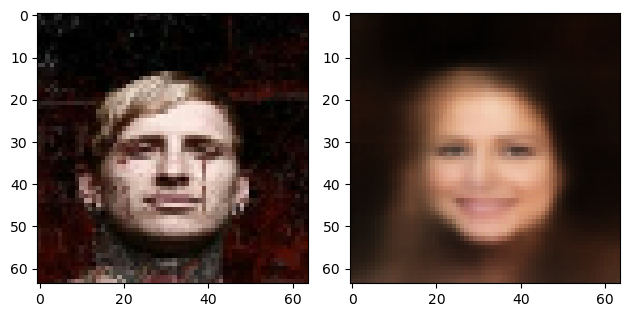

In [44]:
idx = np.random.choice(reconstruction.shape[0])

fig,axs = plt.subplots(1,2)
axs[0].imshow(test_images[idx])
axs[1].imshow(reconstruction[idx])
plt.tight_layout()
plt.show()